# Swift-Hohenberg Equation Simulation in 2D

This notebook simulates the Swift-Hohenberg equation, a standard model for pattern formation, using a spectral method. The equation is solved on a periodic domain with a semi-implicit time-stepping scheme.

The equation is given by:
$$ \frac{\partial u}{\partial t} = \epsilon u - (1 + \nabla^2)^2 u - u^3 $$
where $\epsilon$ is the bifurcation parameter. For $\epsilon > 0$, patterns (typically stripes or spots) emerge.

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

## Parameters
Define the physical and numerical parameters for the simulation.

In [8]:
N = 128          # Grid resolution
L_box = 40.0     # Domain size (large enough to support patterns with wavelength approx 2*pi)
epsilon = 0.1    # Bifurcation parameter (positive for patterns)
dt = 0.1         # Time step
n_steps = 4000   # Total time steps
steps_per_frame = 50 # Animation interval

## Spatial grid and wavenumbers
Set up the computational grid and the corresponding wavenumbers for the Fourier transform.

In [9]:
x = np.linspace(0, L_box, N, endpoint=False)
X, Y = np.meshgrid(x, x)

# Wavenumbers for FFT
k = 2 * np.pi * np.fft.fftfreq(N, d=L_box/N)
Kx, Ky = np.meshgrid(k, k)
K2 = Kx**2 + Ky**2

## Initial condition
The simulation is initialized with small random noise to seed the growth of instabilities.

In [10]:
# Small random noise around zero to seed the instability
np.random.seed(42)
u = 0.1 * (np.random.rand(N, N) - 0.5)

# Transform to Fourier space
u_hat = np.fft.fft2(u)

## Simulation
The simulation uses a semi-implicit Euler scheme in Fourier space. The linear terms (including the bi-Laplacian) are handled implicitly for stability, while the nonlinear term is handled explicitly.

In [11]:
# Spectral operator for the linear part:
# L_linear = epsilon - (1 - K^2)^2
L_linear = epsilon - (1 - K2)**2

# Precompute denominator for semi-implicit Euler step
# Equation: u_t = L_linear * u - u^3
# Semi-implicit Euler: (u_new - u_old)/dt = L_linear * u_new - (u_old)^3
# (1 - dt * L_linear) * u_new = u_old - dt * (u_old)^3
denom = 1 - dt * L_linear

u_movie = []

for i in range(n_steps):
    # Record frame
    if i % steps_per_frame == 0:
        u_real = np.real(np.fft.ifft2(u_hat))
        u_movie.append(u_real)
    
    # Compute nonlinear term in real space: u^3
    u_real = np.real(np.fft.ifft2(u_hat))
    nonlinear = u_real**3
    nonlinear_hat = np.fft.fft2(nonlinear)
    
    # Semi-implicit update
    u_hat = (u_hat - dt * nonlinear_hat) / denom

# Append final state
u_real = np.real(np.fft.ifft2(u_hat))
u_movie.append(u_real)

## Animation
Visualize the time evolution of the system.

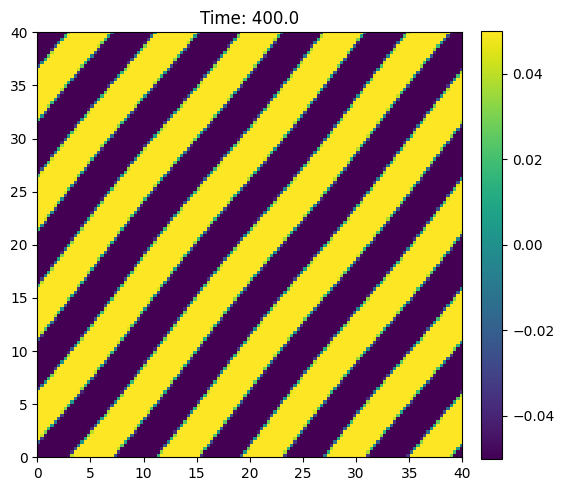

In [12]:
fig, ax = plt.subplots(figsize=(6, 6))
im = ax.imshow(u_movie[0], cmap='viridis', animated=True, origin='lower', extent=[0, L_box, 0, L_box])
ax.set_title('Swift-Hohenberg Evolution')
plt.colorbar(im, fraction=0.046, pad=0.04)

def update(frame):
    im.set_array(u_movie[frame])
    # Auto-scale color limits to see pattern emergence clearly
    # im.set_clim(np.min(u_movie[frame]), np.max(u_movie[frame]))
    ax.set_title(f'Time: {frame * steps_per_frame * dt:.1f}')
    return im,

# Create the animation
anim = FuncAnimation(fig, update, frames=len(u_movie), blit=True, interval=50)

# Display the animation
HTML(anim.to_jshtml())
# HTML(anim.to_html5_video())